## Debug Missing Polygons

In [1]:
from functools import partial
import sys

sys.path.append('../') #Point to folder where plane_folding_utils.py is
from geometric_dl_utils import *
from plane_folding_utils import *
from geometric_dl_utils_simplified import *
from polytope_intersection_utils import intersect_polytopes
from manimlib import *
from tqdm import tqdm

In [2]:
import matplotlib.pyplot as plt

import matplotlib.patches as mp
import cv2
tab20_colors_mpl = plt.cm.tab20_r.colors

In [3]:
map=cv2.imread('Baarle-Nassau_-_Baarle-Hertog-en no legend.png')[:,:,(2,1,0)]

def viz_descision_boundary(model, res=256, figsize=(6,6)):
    plt.clf()
    fig=plt.figure(0,figsize)
    ax=fig.add_subplot(111)
    
    probe=np.zeros((res,res,2))
    for j, xx in enumerate(np.linspace(-1, 1, res)):
        for k, yy in enumerate(np.linspace(-1, 1, res)):
            probe[j, k]=[yy,xx]
    probe=probe.reshape(res**2, -1)
    with torch.no_grad():
        probe_logits=model(torch.tensor(probe).float())
        probe_logits=probe_logits.detach().numpy().reshape(res,res,2)
        probe_softmax = torch.nn.Softmax(dim=1)(torch.tensor(probe_logits.reshape(-1, 2)))
    
    ax.imshow(map.mean(2), cmap='gray', extent=[-1, 1, -1, 1])
    ax.imshow(np.flipud(np.argmax(probe_logits,2)), 
               extent=[-1, 1, -1, 1],  # This maps to image coordinates
               alpha=0.7,
               cmap='viridis')
    return ax

map=cv2.imread('Baarle-Nassau_-_Baarle-Hertog-en no legend.png')[:,:,(2,1,0)]

def viz_descision_boundary(model, res=256, figsize=(6,6)):
    plt.clf()
    fig=plt.figure(0,figsize)
    ax=fig.add_subplot(111)
    
    probe=np.zeros((res,res,2))
    for j, xx in enumerate(np.linspace(-1, 1, res)):
        for k, yy in enumerate(np.linspace(-1, 1, res)):
            probe[j, k]=[yy,xx]
    probe=probe.reshape(res**2, -1)
    with torch.no_grad():
        probe_logits=model(torch.tensor(probe).float())
        probe_logits=probe_logits.detach().numpy().reshape(res,res,2)
        probe_softmax = torch.nn.Softmax(dim=1)(torch.tensor(probe_logits.reshape(-1, 2)))
    
    ax.imshow(map.mean(2), cmap='gray', extent=[-1, 1, -1, 1])
    ax.imshow(np.flipud(np.argmax(probe_logits,2)), 
               extent=[-1, 1, -1, 1],  # This maps to image coordinates
               alpha=0.7,
               cmap='viridis')
    return ax

In [4]:
model = BaarleNet([8, 8, 8])
viz_scales=[0.06, 0.06, 0.042, 0.042, 0.042, 0.042, 0.15]
num_neurons=[8, 8, 8, 8, 8, 8, 2]
vertical_spacing=1.0
graphics_dir='/Users/stephen/Stephencwelch Dropbox/welch_labs/backprop_3/graphics/' 

data_path='/Users/stephen/Stephencwelch Dropbox/welch_labs/backprop_3/hackin/training_caches/8_8_8_2.pkl'
with open(data_path, 'rb') as file:
    training_cache = pickle.load(file) #Training cache

In [5]:
train_step=800

In [6]:
w1=training_cache['weights_history'][train_step]['model.0.weight'].numpy()
b1=training_cache['weights_history'][train_step]['model.0.bias'].numpy()
w2=training_cache['weights_history'][train_step]['model.2.weight'].numpy()
b2=training_cache['weights_history'][train_step]['model.2.bias'].numpy()
w3=training_cache['weights_history'][train_step]['model.4.weight'].numpy()
b3=training_cache['weights_history'][train_step]['model.4.bias'].numpy()

with torch.no_grad():
    model.model[0].weight.copy_(torch.from_numpy(w1))
    model.model[0].bias.copy_(torch.from_numpy(b1))
    model.model[2].weight.copy_(torch.from_numpy(w2))
    model.model[2].bias.copy_(torch.from_numpy(b2))
    model.model[4].weight.copy_(torch.from_numpy(w3))
    model.model[4].bias.copy_(torch.from_numpy(b3))

In [7]:
w1.shape

(8, 2)

In [8]:
polygons={} #dict of all polygones as we go. 
polygons['-1.new_tiling']=[np.array([[-1., -1, 0], #First polygon is just input plane
                                    [-1, 1, 0], 
                                    [1, 1, 0], 
                                    [1, -1, 0]])]

for layer_id in range(len(model.model)//2): #Move polygont through layers     
    polygons[str(layer_id)+'.linear_out']=process_with_layers(model.model[:2*layer_id+1], polygons[str(layer_id-1)+'.new_tiling']) 

    #Split polygons w/ Relu and clip negative values to z=0
    polygons[str(layer_id)+'.split_polygons_nested']=split_polygons_with_relu_simple(polygons[str(layer_id)+'.linear_out']) #Triple nested list so we can simplify merging process layer. 
    polygons[str(layer_id)+'.split_polygons_nested_clipped'] = clip_polygons(polygons[str(layer_id)+'.split_polygons_nested'])
    #Merge zero regions
    polygons[str(layer_id)+'.split_polygons_merged'] = merge_zero_regions(polygons[str(layer_id)+'.split_polygons_nested_clipped'])
    
    #Compute new tiling - general method with merging - should be more accurate but slow - buggy?
    # polygons[str(layer_id)+'.new_tiling']=recompute_tiling_general(polygons[str(layer_id)+'.split_polygons_merged'])
    
    #Less general method - less accurate, faster, maybe less buggy
    polygons[str(layer_id)+'.new_tiling_nested']=recompute_tiling_polygonize(polygons[str(layer_id)+'.split_polygons_nested'], min_area=0)
    polygons[str(layer_id)+'.new_tiling']=[item for sublist in polygons[str(layer_id)+'.new_tiling_nested'] for item in sublist]


    print('Retiled plane into ', str(len(polygons[str(layer_id)+'.new_tiling'])), ' polygons.')
    #Optional filtering step
    #polygons[str(layer_id)+'.new_tiling'] = filter_small_polygons(polygons[str(layer_id)+'.new_tiling'], min_area=1e-5)
    #print(str(len(polygons[str(layer_id)+'.new_tiling'])), ' polygons remaining after filtering out small polygons')


#Last linear layer & output
polygons[str(layer_id+1)+'.linear_out']=process_with_layers(model.model, polygons[str(layer_id)+'.new_tiling'])
intersection_lines, new_2d_tiling, upper_polytope, indicator = intersect_polytopes(*polygons[str(layer_id+1)+'.linear_out'])
my_indicator, my_top_polygons = compute_top_polytope(model, new_2d_tiling)

Retiled plane into  20  polygons.
Retiled plane into  185  polygons.
Retiled plane into  505  polygons.


(-1.1, 1.1)

<Figure size 640x480 with 0 Axes>

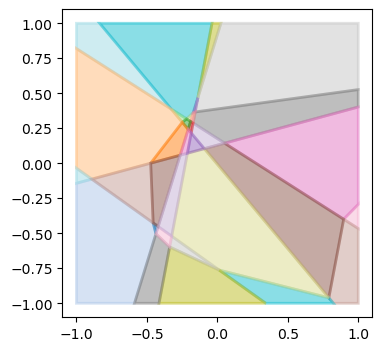

In [9]:
split_polygons=[item for sublist in polygons['1.split_polygons_nested'][0] for item in sublist]

plt.clf()
fig=plt.figure(0, (4,4))
ax=fig.add_subplot(111)
for j, p in enumerate(split_polygons):    
    if len(p)<3: continue
    poly=mp.Polygon(p[:,:2].tolist(), facecolor=tab20_colors_mpl[j%len(tab20_colors_mpl)], 
                    edgecolor=tab20_colors_mpl[j%len(tab20_colors_mpl)], linewidth=2, alpha=0.5)
    ax.add_patch(poly)
plt.xlim([-1.1, 1.1]); plt.ylim([-1.1, 1.1])

(-1.1, 1.1)

<Figure size 640x480 with 0 Axes>

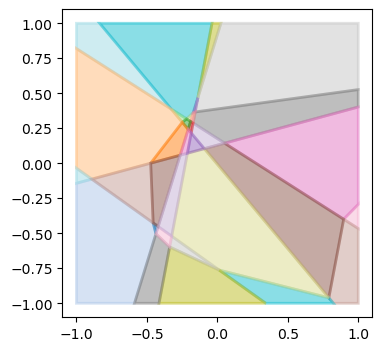

In [10]:
split_polygons=[item for sublist in polygons['1.split_polygons_nested'][0] for item in sublist]

plt.clf()
fig=plt.figure(0, (4,4))
ax=fig.add_subplot(111)
for j, p in enumerate(split_polygons):    
    if len(p)<3: continue
    poly=mp.Polygon(p[:,:2].tolist(), facecolor=tab20_colors_mpl[j%len(tab20_colors_mpl)], 
                    edgecolor=tab20_colors_mpl[j%len(tab20_colors_mpl)], linewidth=2, alpha=0.5)
    ax.add_patch(poly)
plt.xlim([-1.1, 1.1]); plt.ylim([-1.1, 1.1])

(-1.1, 1.1)

<Figure size 640x480 with 0 Axes>

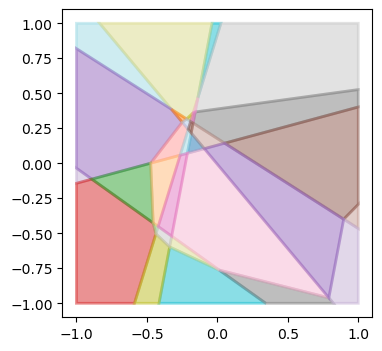

In [72]:
len(polygons['0.new_tiling'])

20

(-1.0, 1.0)

<Figure size 640x480 with 0 Axes>

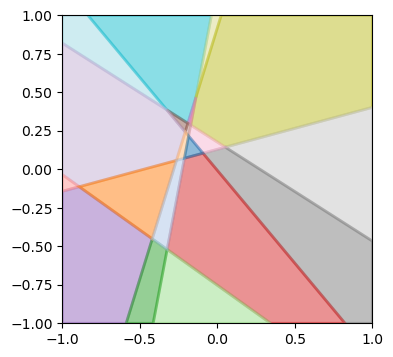

In [11]:
plt.clf()
fig=plt.figure(0, (4,4))
ax=fig.add_subplot(111)
for j, p in enumerate(polygons['0.new_tiling']):    
    if len(p)<3: continue
    # print(p)
    poly=mp.Polygon(p[:,:2].tolist(), facecolor=tab20_colors_mpl[j%len(tab20_colors_mpl)], 
                    edgecolor=tab20_colors_mpl[j%len(tab20_colors_mpl)], linewidth=2, alpha=0.5)
    ax.add_patch(poly)
plt.xlim([-1, 1]); plt.ylim([-1, 1])

(-1.1, 1.1)

<Figure size 640x480 with 0 Axes>

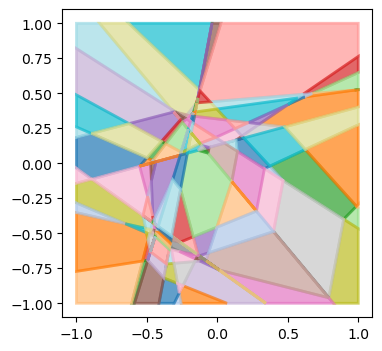

In [15]:
plt.clf()
fig=plt.figure(0, (4,4))
ax=fig.add_subplot(111)
for j, p in enumerate(polygons['1.new_tiling']):    
    if len(p)<3: continue
    poly=mp.Polygon(p[:,:2].tolist(), facecolor=tab20_colors_mpl[j%len(tab20_colors_mpl)], 
                    edgecolor=tab20_colors_mpl[j%len(tab20_colors_mpl)], linewidth=2, alpha=0.7)
    ax.add_patch(poly)
plt.xlim([-1.1, 1.1]); plt.ylim([-1.1, 1.1])

(-1.0, 1.0)

<Figure size 640x480 with 0 Axes>

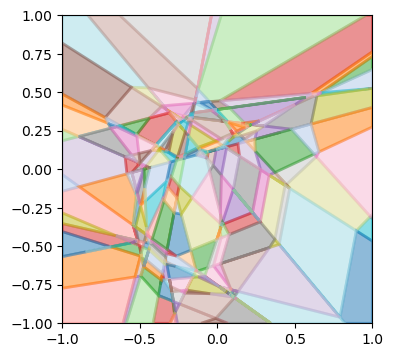

In [13]:
plt.clf()
fig=plt.figure(0, (4,4))
ax=fig.add_subplot(111)
for j, p in enumerate(polygons['2.new_tiling']):    
    if len(p)<3: continue
    poly=mp.Polygon(p[:,:2].tolist(), facecolor=tab20_colors_mpl[j%len(tab20_colors_mpl)], 
                    edgecolor=tab20_colors_mpl[j%len(tab20_colors_mpl)], linewidth=2, alpha=0.5)
    ax.add_patch(poly)
plt.xlim([-1, 1]); plt.ylim([-1, 1])

<Figure size 640x480 with 0 Axes>

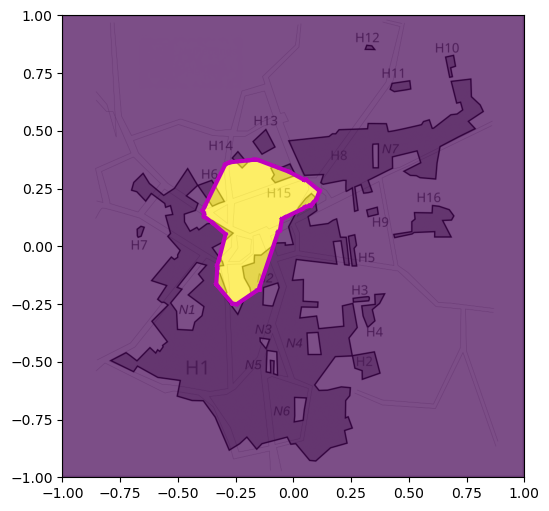

In [13]:
ax=viz_descision_boundary(model)
for l in intersection_lines:
    ax.plot(l[:,0], l[:,1], c='m', linewidth=3)

<Figure size 640x480 with 0 Axes>

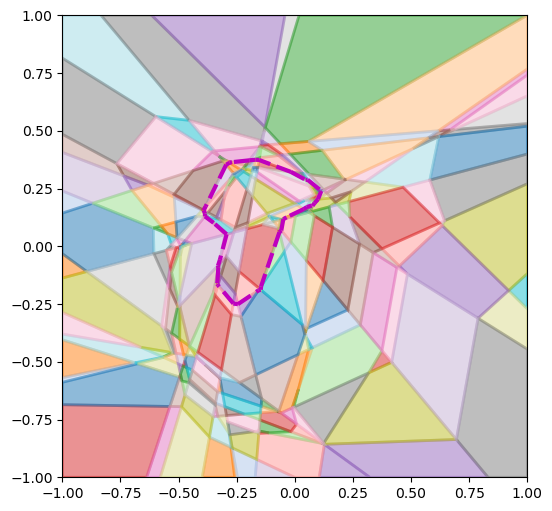

In [14]:
plt.clf()
fig=plt.figure(0, (6,6))
ax=fig.add_subplot(111)
for j, p in enumerate(new_2d_tiling):    
    if len(p)<3: continue
    poly=mp.Polygon(p[:,:2].tolist(), facecolor=tab20_colors_mpl[j%len(tab20_colors_mpl)], 
                    edgecolor=tab20_colors_mpl[j%len(tab20_colors_mpl)], linewidth=2, alpha=0.5)
    ax.add_patch(poly)
for l in intersection_lines:
    ax.plot(l[:,0], l[:,1], 'm--', linewidth=3, )
plt.xlim([-1,1]); plt.ylim([-1,1]);